## Constant fractional timing (CFT)

Here is a note to show how to simulate a CFT by using the data taking from osciliscope. The basic steps are:

1. Duplicate an opposite signal from the input siganl;
2. Scale the duplicated signal down by a constant fraction c;
3. Delay the original signal by Dt;
4. Supperposition the two signals together and then the cross over is the CFT.

The baseline is important to any timing and it will also affect the CFT as well.

In [76]:
from mtdScope import scopeEmulator
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy import optimize
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline

#from jupyterthemes import jtplot
#jtplot.style()
#import mtdProcess as mp
        
#load the sample data to test
se = scopeEmulator()
se.loadData()
#se.loadData('./HV160_lowPower_100mV_11340R.hd5')
se.sliceEvent()
class cftiming:
    def __init__(self):
        self.gain = 0.5
        self.delay = 1000 # delay 1000 ps

    def normalizeY(self, points):
        scale = points[np.argmax(np.abs(points))]
        return np.multiply(points, 1.0/scale)

    def crossFinder(self, y):
        jmin = y.argmin()
        jmax = y.argmax()
        print(y)
        x = np.where(np.diff(np.sign(y)))[0]
        arr1 = np.where(x<jmax)
        if len(arr1[0]) == 0: return -2
        arr1 = arr1[0][-1]
        return int(x[arr1])

    def simulateCFT(self, xs, ys, dt):
        frac = self.gain 
        delayInterval = int(self.delay/dt) 
        f = InterpolatedUnivariateSpline(xs, ys) 
        def simCFT( x): 
            return f(x-delayInterval*dt)-frac*f(x)
        return simCFT

    def getCFTiming(self, t, y):
        y = self.normalizeY(y)
        dt = t[1]-t[0]
        ntrun =int(np.floor(2000/dt))
        ymax = np.amax(y)
        halfy = np.where(y > ymax*self.gain*0.9)[0]
        t0 = halfy[0]
        t1 = halfy[-1]
        f = self.simulateCFT(t, y, dt) 
        yy = f(t[ntrun:-ntrun])
        yys = yy[t0-ntrun:t1-ntrun]
        plt.plot(points[0][t0:t1],yys)
        x0 = self.crossFinder(yys) 
        if x0 < 0 : return -1
#        inte = [t[x0+ntrun], t[x0+1+ntrun]]
        inte = [t[t0+x0], t[t0+x0+1]]
        x1 = inte[0]
        x2 = inte[1]
        k = (f(x2)-f(x1))/(x2-x1)
        cft = x1-f(x1)/k
        return cft 


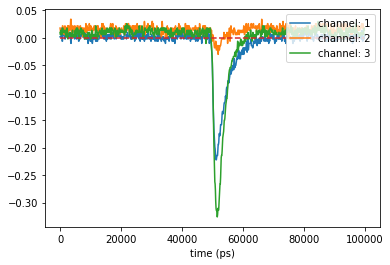

In [7]:
se.showEvent(1, [1,2,3])

[-0.26576577 -0.31981982 -0.32882883 -0.34684685 -0.35585586 -0.34684685
 -0.32882883 -0.3018018  -0.22972973 -0.12162162 -0.02252252  0.08558559
  0.18468468  0.26576577  0.31981982  0.37387387  0.43693694  0.47297297
  0.50900901  0.55405405  0.5990991   0.60810811  0.58108108  0.56306306
  0.59009009  0.60810811  0.55405405  0.51801802  0.51801802  0.51801802
  0.49099099  0.48198198  0.5         0.49099099  0.43693694  0.41891892
  0.43693694  0.44594595  0.44594595  0.40990991  0.36486486  0.36486486
  0.35585586]
51220.833333333336


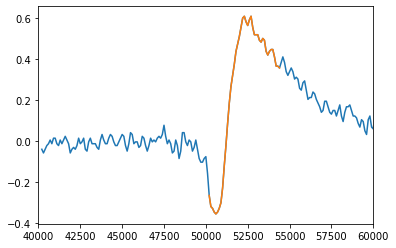

In [79]:
timer = cftiming()
points = se.getEventAdjusted(1)
p = timer.normalizeY(points[1])
dt = points[0][1]-points[0][0]
ymax = np.amax(p)
t0 = np.where(p > ymax*0.4)[0][0]
t1 = np.where(p > ymax*0.4)[0][-1]
#t1 = t0+int(1000/dt)

# cft = timer.simulateCFT(points[0],p, dt)
#plt.plot(points[0],p)
# plt.plot(points[0][t0:t1], p[t0:t1])
plt.plot(points[0][t0-100:t1+100], cft(points[0][t0-100:t1+100]))
# #plt.plot(points[0][t0:t1], cft(points[0][t0:t1]))
# plt.plot(points[0][t0:t1], cft(points[0][t0:t1]))
plt.xlim(40000,60000)
print(timer.getCFTiming(points[0],points[1]))
